# 飞桨常规赛：PALM眼底彩照视盘探测与分割 5月第7名方案

```
详细的记不太清了，可以参考我的代码，PaddleSeg我好像改过一部分东西
```

In [ ]:
#导入PaddleSeg
!git clone https://gitee.com/paddlepaddle/PaddleSeg.git

Cloning into 'PaddleSeg'...
remote: Enumerating objects: 11141, done.
remote: Counting objects: 100% (11141/11141), done.
remote: Compressing objects: 100% (5537/5537), done.
remote: Total 11141 (delta 7554), reused 8284 (delta 5439), pack-reused 0
Receiving objects: 100% (11141/11141), 157.00 MiB | 24.60 MiB/s, done.
Resolving deltas: 100% (7554/7554), done.
Checking connectivity... done.


In [ ]:
#解压数据集至data/目录
!unzip -oq /home/aistudio/data/data85136/常规赛：PALM眼底彩照视盘探测与分割.zip -d data/

In [ ]:
import sys
sys.path.append("PaddleSeg")
import paddleseg
import paddle
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import random
#设置随机数种子
random.seed(2021)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matp

In [ ]:
def write_txt(file_name, data, mode):
    assert mode=="train" or mode=="val" or mode=="test", "ERROR:mode must be train, val or test."
    if mode!="test":
        with open(file_name, 'w') as f:
            for path in data:
                label_path = os.path.join(train_path, dir_list[0], path.replace('jpg', 'bmp'))
                img_path = os.path.join(train_imgs_path, path)
                f.write(img_path+","+str(label_path)+"\n")
    else:
        with open(file_name, 'w') as f:
            for path in data:
                img_path = os.path.join(test_path, path)
                f.write(img_path+"\n")

In [ ]:
def create_txt(data_root, train_dir=None, test_dir=None, val_pro=0.2, is_cross_val=False, k=None):#当is_cross_val=True时，k必须有正整值
    if train_dir is not None:
        if os.path.exists("train.txt"):
            os.remove("train.txt")
        if os.path.exists("val.txt"):
            os.remove("val.txt")
        global train_path, dir_list, train_imgs_path
        train_path = os.path.join(data_root, train_dir)
        dir_list = os.listdir(train_path)#['Disc_Masks', '.DS_Store', 'fundus_image']
        train_imgs_path = os.path.join(train_path, dir_list[2])
        all_train_data = os.listdir(train_imgs_path)
        #打乱数据
        random.shuffle(all_train_data)
        if is_cross_val is False:
            val_len = int(len(all_train_data)*val_pro)
            val_data = all_train_data[:val_len]
            train_data = all_train_data[val_len:]
            write_txt("train.txt", train_data, mode="train")
            write_txt("val.txt", val_data, mode="val")
        else:
            val_len = len(all_train_data)//k
            for m in range(k):
                val_data = all_train_data[val_len*m:val_len*(m+1)]
                train_data = np.concatenate([all_train_data[:val_len*m], all_train_data[val_len*(m+1):]], axis=0)
                train_txt = "train_"+str(m)+".txt"
                val_txt = "val_"+str(m)+".txt"
                write_txt(train_txt, train_data, mode="train")
                write_txt(val_txt, val_data, mode="val")
    print("训练数据整理完毕！训练集长度：{}，验证集长度：{}".format(len(train_data), val_len))

    if test_dir is not None:
        if os.path.exists("test.txt"):
            os.remove("test.txt")
        global test_path
        test_path = os.path.join(data_root, test_dir)
        test_imgs_path_list = sorted(os.listdir(test_path))
        write_txt("test.txt", test_imgs_path_list, mode="test")
    print("测试数据整理完毕！测试集长度：{}".format(len(test_imgs_path_list)))

In [ ]:
data_root = "data/常规赛：PALM眼底彩照视盘探测与分割"
train_dir = "Train"
test_dir = "PALM-Testing400-Images"
create_txt(data_root=data_root, train_dir=train_dir, test_dir=test_dir)#, is_cross_val=True, k=5)

训练数据整理完毕！训练集长度：640，验证集长度：160
测试数据整理完毕！测试集长度：400


In [ ]:
#验证一下是否写入正确，可以直接点开文件查看
#也可以读取文件内容查看
#以train.txt为例，只看前5行验证
count = 5
with open('train.txt', 'r')  as f:
    for line in f.readlines():
        print(line)
        count -= 1
        if count==0:
            break

data/常规赛：PALM眼底彩照视盘探测与分割/Train/fundus_image/V0210.jpg,data/常规赛：PALM眼底彩照视盘探测与分割/Train/Disc_Masks/V0210.bmp

data/常规赛：PALM眼底彩照视盘探测与分割/Train/fundus_image/N0090.jpg,data/常规赛：PALM眼底彩照视盘探测与分割/Train/Disc_Masks/N0090.bmp

data/常规赛：PALM眼底彩照视盘探测与分割/Train/fundus_image/V0050.jpg,data/常规赛：PALM眼底彩照视盘探测与分割/Train/Disc_Masks/V0050.bmp

data/常规赛：PALM眼底彩照视盘探测与分割/Train/fundus_image/P0091.jpg,data/常规赛：PALM眼底彩照视盘探测与分割/Train/Disc_Masks/P0091.bmp

data/常规赛：PALM眼底彩照视盘探测与分割/Train/fundus_image/P0169.jpg,data/常规赛：PALM眼底彩照视盘探测与分割/Train/Disc_Masks/P0169.bmp



img shape: (2056, 2124, 3)
label shape: (2056, 2124)
classes: [  0 255]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


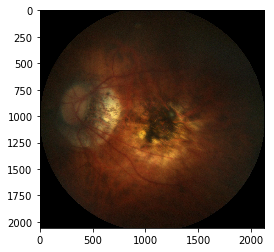

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


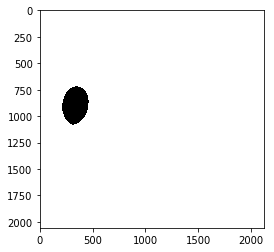

In [ ]:
#随便展示一张图片及其它的label
%matplotlib inline
path = line.strip().split(",")
#path= ["data/常规赛：PALM眼底彩照视盘探测与分割/Train/fundus_image/V0381.jpg","data/常规赛：PALM眼底彩照视盘探测与分割/Train/Disc_Masks/V0381.bmp"]
img = plt.imread(path[0])
label = plt.imread(path[1])
print("img shape:", img.shape)
print("label shape:", label.shape)
print("classes:", np.unique(label))
plt.imshow(img)
plt.show()
plt.imshow(label, cmap='gray')
plt.show()

## 切分图片

In [ ]:
length = 512
new_path = "new_imgs_labels_512"
new_path_list = []
with open("new_train_list.txt", 'r') as f:
    for line in tqdm(f):
        path_list = line.strip().split(",")
        img = plt.imread(path_list[0])
        label = plt.imread(path_list[1])
        if img.shape[:-1]==label.shape[:]:
            rows = np.argwhere(label==0)[:,0]
            cols = np.sort(np.argwhere(label==0)[:,1])
            rows_len = rows[-1]-rows[0]
            cols_len = cols[-1]-cols[0]
            pad_rows = (length-rows_len)//2
            pad_cols = (length-cols_len)//2
            rows_index = [max(rows[0]-pad_rows, 0), min(max(rows[0]-pad_rows, 0)+length, img.shape[0])]
            cols_index = [max(cols[0]-pad_cols, 0), min(max(cols[0]-pad_cols, 0)+length, img.shape[1])]
            new_label = label[rows_index[0]:rows_index[1], cols_index[0]:cols_index[1]]
            new_img = img[rows_index[0]:rows_index[1], cols_index[0]:cols_index[1]]
            new_img_path = os.path.join(new_path, path_list[0].split("/")[-1])
            new_label_path = os.path.join(new_path, path_list[1].split("/")[-1])
            #print(cols_index)
            Image.fromarray(new_img.astype("uint8")).save(new_img_path)
            Image.fromarray(new_label.astype("uint8")).save(new_label_path)
            new_path_list.append([new_img_path, new_label_path])
with open("./new_train_512.txt", 'w') as f:
    for path in tqdm(new_path_list):
        f.writelines(path[0] + "," + path[1] + '\n')

# 参数配置及训练

```
my_ocr.yml:
batch_size: 4
iters: 4000

train_dataset:
  type: Dataset
  dataset_root: /home/aistudio
  train_path: /home/aistudio/new_train_512.txt
  num_classes: 2
  transforms:
    - type: RandomHorizontalFlip
    - type: RandomVerticalFlip
    - type: RandomDistort
      brightness_range: 0.4
      contrast_range: 0.4
      saturation_range: 0.4
    - type: Resize
      target_size: [512, 512]
    - type: Normalize
  mode: train

val_dataset:
  type: Dataset
  dataset_root: /home/aistudio
  val_path: /home/aistudio/val.txt
  num_classes: 2
  transforms:
    - type: Resize
      target_size: [1444, 1444]
    - type: Normalize
  mode: val


model:
  type: OCRNet
  backbone:
    type: HRNet_W48

    pretrained: https://bj.bcebos.com/paddleseg/dygraph/hrnet_w48_ssld.tar.gz
  num_classes: 2
  #use_deconv: False
  pretrained: output_ocr/iter_2000/model.pdparams
  backbone_indices: [0]

optimizer:
  type: sgd
  #weight_decay: 0.001

learning_rate:
  value: 0.001
  decay:
    type: poly
    power: 0.9
    end_lr: 0.00001
    



loss:
  types:
    - type: MixedLoss
      losses:
        - type: CrossEntropyLoss
        #- type: LovaszSoftmaxLoss
        - type: DiceLoss
      coef: [0.5, 0.5]
    - type: MixedLoss
      losses:
        - type: CrossEntropyLoss
        #- type: LovaszSoftmaxLoss
        - type: DiceLoss
      coef: [0.5, 0.5]
  coef: [1, 0.5]
```

In [ ]:
!python PaddleSeg/train.py --config my_ocr.yml --do_eval --use_vdl --save_dir /home/aistudio/output_ocr2 #--resume_model output_ocr/iter_1200

# 推理

In [3]:
#推理
!python PaddleSeg/predict.py --config my_ocr.yml --model_path output_ocr2/best_model/model.pdparams --image_path data/常规赛：PALM眼底彩照视盘探测与分割/PALM-Testing400-Images --save_dir output/result #--aug_pred --flip_horizontal --flip_vertical

In [4]:
%cd output/result/results
!zip -r -oq /home/aistudio/Disc_Segmentation.zip ./
%cd /home/aistudio

/home/aistudio/output/result/results
/home/aistudio
